In [1]:
import glob
import pickle
import json
import os
import pickle

import torch
import numpy as np
from natsort import natsorted
from tqdm import tqdm

from integrated_cell import model_utils, utils

In [13]:
gpu_ids = [2]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()
    
image_parent = '/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/'

In [14]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path(image_parent) / "data_jobs_out.csv")

In [15]:
Path(df.sample().save_reg_path.item()).exists()

True

In [16]:
from aicsimageio import AICSImage
from PIL import Image

In [17]:
img = AICSImage(df.sample().save_reg_path.item())

In [18]:
img.get_channel_names()

['0', '1', '2', '3', '4', '5']

In [19]:
data = img.get_image_data("CZYX", S=0, T=0)
data.shape

(6, 64, 168, 104)

In [20]:
c = 1
foo = img.data[0,0,c,:,:,:]

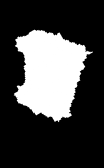

In [21]:
Image.fromarray(foo.max(axis=0))

In [22]:
from integrated_cell.data_providers.DataProvider import DataProvider

In [89]:
dp = DataProvider(
    "/raid/shared/ipp/scp_19_04_10/",
    16,
    csv_name="controls/data_plus_controls.csv",
    check_files=False,
    channelInds=[3,1,4],
    normalize_intensity="max",
)

reading csv manifest


In [90]:
a,b,c = dp.get_sample()

(168, 104, 64)


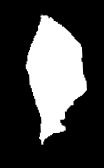

In [97]:
n=8
c=0
img_np = a[n].numpy()
print(img_np[c].shape)
im_arr = np.max(img_np[c], axis=2)
im_arr = (255*im_arr/im_arr.max()).astype(np.uint8)
Image.fromarray(im_arr)

In [95]:
img_np[2].max()

1.0

In [242]:
import os
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
import tifffile
from PIL import Image
from integrated_cell.utils.utils import str2rand

from integrated_cell.data_providers.DataProviderABC import DataProviderABC


class SegmentationDataProviderRef(DataProviderABC):
    def __init__(
        self,
        image_parent="/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/",
        csv_name="data_jobs_out.csv",
        image_col = "save_reg_path",
        channelInds=[0,1],
        target_col="StructureId/Name",
        batch_size=16,
        n_dat=-1,
        hold_out=0.1,
        verbose=True,
        check_files=True,
        split_seed=1,
        return2D=False,
        slab_width=None,
        rescale_to=None,
        crop_to=None,
        make_controls=False,
        normalize_intensity=True,
    ):

        self.hold_out = hold_out
        self.verbose = verbose
        self.channelInds = channelInds
        self.check_files = check_files
        self.split_seed = split_seed
        self.crop_to = crop_to
        self.rescale_to = rescale_to
        self.image_parent = image_parent
        self.image_col = image_col
        self.csv_name = csv_name
        self.normalize_intensity = normalize_intensity
        self.return2D = return2D
        self.slab_width = slab_width
        self.batch_size = batch_size
        self.target_col = target_col

        # make a dataframe out of the csv log file
        csv_path = os.path.join(self.image_parent, self.csv_name)
        if self.verbose:
            print("reading csv manifest")
        csv_df = pd.read_csv(csv_path)
        self.csv_data = csv_df
        
        # rewire paths to images to be relative to image_parent
        df[self.image_col] = df[self.image_col].apply(
            lambda p: Path(image_parent) / Path(p).relative_to(Path(p).parent.parent)
        )

        # check which rows in csv are valid, based on all the channels i want being present
        if self.check_files:
            if self.verbose:
                print("Checking the existence of files")

            for index, row in tqdm(csv_df.iterrows(), total=len(csv_df)):
                is_good_row = True

                image_path = row[self.image_col]

                try:
                    self.load_image(row)
                except:  # noqa
                    print(f"Could not load from image. {image_path}")
                    is_good_row = False

                csv_df.loc[index, "valid_row"] = is_good_row

            # only work with valid rows
            n_old_rows = len(csv_df)
            csv_df = csv_df.loc[csv_df["valid_row"] == True]  # noqa
            csv_df = csv_df.drop("valid_row", 1)
            n_new_rows = len(csv_df)
            if self.verbose:
                print(
                    f"{n_new_rows}/{n_old_rows} samples have all files present"
                )

        # Psuedorandomly deterministically convert the cellID
        # to a number for train/validation/test splits
        rand_split = str2rand(csv_df["CellId"], self.split_seed)
        rand_dna_memb = str2rand(csv_df["CellId"], self.split_seed + 1)

        # log rand splits to df
        csv_df["rand_split"] = rand_split
        csv_df["rand_dna_memb"] = rand_dna_memb

        # reset df index
        csv_df = csv_df.reset_index()
        
        # get label data
        image_classes = list(csv_df[self.target_col])
        self.csv_data = csv_df
        self.image_classes = image_classes

        nimgs = len(csv_df)

        [label_names, labels] = np.unique(image_classes, return_inverse=True)
        self.label_names = label_names

        onehot = np.zeros((nimgs, np.max(labels) + 1))
        onehot[np.arange(nimgs), labels] = 1

        self.labels = labels
        self.labels_onehot = onehot

        # save data dict -- which indices in df are in which split
        self.data = {
            "test": {
                "inds": np.where(csv_df["rand_split"] <= self.hold_out)[0]
            },
            "validate": {
                "inds": np.where(
                    (csv_df["rand_split"] > self.hold_out)
                    & (csv_df["rand_split"] <= self.hold_out * 2)
                )[0]
            },
            "train": {
                "inds": np.where(csv_df["rand_split"] > self.hold_out * 2)[0]
            },
        }

        # save out image size for later
        self.imsize = self.load_image(csv_df.iloc[0]).shape

        # initialze dict of embedding tensors
        self.embeddings = {
            "train": torch.zeros([len(self.data["train"]["inds"]), 0]),
            "test": torch.zeros([len(self.data["test"]["inds"]), 0]),
            "validate": torch.zeros(
                [len(self.data["validate"]["inds"]), 0]
            ),
        }

        # i don't get this n_dat stuff
        if n_dat == -1:
            self.n_dat = {"train": len(self.data["train"]["inds"])}
        else:
            self.n_dat = {"train": n_dat}
        self.n_dat["validate"] = len(self.data["validate"]["inds"])
        self.n_dat["test"] = len(self.data["test"]["inds"])

        
    def load_image(self, row):
        aicsimg = AICSImage(row[self.image_col])
        im_tmp = aicsimg.get_image_data("CZYX", S=0, T=0)
        im = im_tmp[self.channelInds]
        if self.normalize_intensity:
            im = im.astype(np.float32)
            for i, ch in enumerate(im):
                im[i] = ch / np.max(ch)
        
        if self.return2D:
            _,z,_,_ = im.shape
            slab_width = 8 if self.slab_width is None else self.slab_width
            im = im[:,(z-slab_width)//2:(z+slab_width)//2,...].max(axis=1)
            
        return im

    
    def set_n_dat(self, n_dat, train_or_test="train"):
        if n_dat == -1:
            self.n_dat[train_or_test] = len(self.data[train_or_test]["inds"])
        else:
            self.n_dat[train_or_test] = n_dat

            
    def get_n_dat(self, train_or_test="train", override=False):

        if override:
            n_dat = len(self.data[train_or_test]["inds"])
        else:
            n_dat = self.n_dat[train_or_test]

        return n_dat

    
    def __len__(self, train_or_test="train"):
        return self.get_n_dat(train_or_test)

    
    def get_image_paths(self, inds_tt, train_or_test):
        inds_master = self.data[train_or_test]["inds"][inds_tt]
        return list(self.csv_data[self.image_col][inds_master])

    # this is wild
    def get_images(self, inds_tt, train_or_test):
        dims = list(self.imsize)
        dims[0] = len(self.channelInds)
        dims.insert(0, len(inds_tt))

        inds_master = self.data[train_or_test]["inds"][inds_tt]

        images = torch.zeros(tuple(dims))

        for i, (rownum, row) in enumerate(self.csv_data.iloc[inds_master].iterrows()):
            image = self.load_image(row)
            images[i] = torch.from_numpy(image)

        if self.rescale_to is not None:
            images = torch.nn.functional.interpolate(
                images, scale_factor=self.rescale_to
            )

        if self.crop_to is not None:
            crop = (np.array(images.shape[2:]) - np.array(self.crop_to)) / 2
            crop_pre = np.floor(crop).astype(int)
            crop_post = np.ceil(crop).astype(int)

            pad_pre = -crop_pre
            pad_pre[pad_pre < 0] = 0

            pad_post = -crop_post
            pad_post[pad_post < 0] = 0

            crop_pre[crop_pre < 0] = 0

            crop_post[crop_post < 0] = 0
            crop_post[crop_post == 0] = -np.array(images.shape[2:])[crop_post == 0]

            if len(crop_pre) == 2:
                images = images[
                    :,
                    :,
                    crop_pre[0] : -crop_post[0],  # noqa
                    crop_pre[1] : -crop_post[1],  # noqa
                ]

            elif len(crop_pre) == 3:
                images = images[
                    :,
                    :,
                    crop_pre[0] : -crop_post[0],  # noqa
                    crop_pre[1] : -crop_post[1],  # noqa
                    crop_pre[2] : -crop_post[2],  # noqa
                ]

            pad_pre = np.hstack([np.zeros(2), pad_pre])
            pad_post = np.hstack([np.zeros(2), pad_post])
            padding = np.vstack([pad_pre, pad_post]).transpose().astype("int")
            images = np.pad(images, padding, mode="constant", constant_values=0)
            images = torch.tensor(images)

        return images

    def get_classes(self, inds_tt, train_or_test, index_or_onehot="index"):
        inds_master = self.data[train_or_test]["inds"][inds_tt]

        if index_or_onehot == "index":
            labels = self.labels[inds_master]
        else:
            labels = np.zeros([len(inds_master), self.get_n_classes()])
            for c, i in enumerate(inds_master):
                labels[c, :] = self.labels_onehot[i, :]

            labels = torch.from_numpy(labels).long()

        labels = torch.LongTensor(labels)
        return labels

    def get_n_classes(self):
        return self.labels_onehot.shape[1]

    def set_ref(self, embeddings):
        self.embeddings = embeddings

    def get_ref(self, inds, train_or_test="train"):
        inds = torch.LongTensor(inds)
        return self.embeddings[train_or_test][inds]

    def get_n_ref(self):
        return self.get_ref([0], "train").shape[1]

    def get_sample(self, train_or_test="train", inds=None):
        if inds is None:
            rand_inds = np.random.permutation(self.get_n_dat(train_or_test))
            inds = rand_inds[0 : self.batch_size]  # noqa
        x = self.get_images(inds, train_or_test)
        return x

In [243]:
dp = SegmentationDataProviderRef(check_files=False, return2D=True, slab_width=8)

reading csv manifest


In [244]:
x = dp.get_sample("train", inds=[0,1,2222,3,4])

In [245]:
dp.get_classes([0,1111,2222,6666], "train")

tensor([ 9,  9, 12,  0])

In [246]:
dp.get_image_paths([9,999], "test")

['/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/plate_3500001506/8383_753_reg.tiff',
 '/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/plate_3500001310/6271_38369_reg.tiff']

In [247]:
dp.get_images([33,1111, 0], "train").shape

torch.Size([3, 2, 168, 104])

In [248]:
dp.get_sample().shape

torch.Size([16, 2, 168, 104])